In [4]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from datetime import datetime

In [26]:
folder = 'Data'
filename = 'SCE_Usage_3-016-0030-82_10-15-16_to_11-08-17.csv'
filepath = os.path.join(folder, filename)

def csv_to_df(filepath):
    '''
    USAGE: Clean CSV contents and read them into a DataFrame.
    ARGUMENT: filepath -- location of CSV data file
    RETURNS: df -- Pandas DataFrame with columns ['time_window', 'dWh']
    '''
    with open(filepath, 'r') as fp:
        text = fp.read()
    re_string = r'Reading quality\n([\s\S]*?),,\n'
    matches = re.findall(re_string, text)
    text = ''.join(matches)
    
    new_filepath = filepath.split('.csv')[0] + '_cleaned.csv'
    with open(new_filepath, 'w') as fp:
        text = 'time_window, kWh, reading_quality\n' + text
        fp.write(text)
    
    df = pd.DataFrame.from_csv(new_filepath, encoding = "ISO-8859-1") 
    df = df.iloc[:-1]
    df.columns = ['kWh', 'reading_quality']
    df.reset_index(inplace = True)
    df = df[['time_window', 'kWh']]
    
    return df

def str2timestamp(df):
    '''
    USAGE: Convert string-formatted time data into timestamps
    ARGUMENT: df -- DataFrame with columns ['time_window', 'dWh']
    RETURNS: df -- DataFrame with timestamp-formatted 'time_window' column
    '''
    df.time_window[1]
    pattern = r'(.*?)\xa0to'

    time_window_list = list(df.time_window)

    for i, v in enumerate(time_window_list):
        time = v.split('\xa0to')[0]
        time_window_list[i] = datetime.strptime(time, '%Y-%m-%d %H:%M:%S')

    df['time_window'] = time_window_list
    
    return df

In [27]:
df = csv_to_df(filepath)
df = str2timestamp(df)

In [29]:
def moving_avg(my_list, bias=0.5):
    '''
    USAGE: Create a moving average (exponentially weighted) of power data.
    
    ARGUMENTS: 
    my_list -- list of data values
    bias -- smoothness of averaging (between 0 and 1, where 1 is smoothest)
    
    RETURNS: new_list -- list of exponentially weighted data values
    '''
    
    new_list = [my_list[0]]
    
    for i in range(len(my_list)-1):
        new_point = bias * new_list[-1] + (1 - bias) * my_list[i + 1]
        new_list.append(new_point)
    
    return new_list

<IPython.core.display.Javascript object>


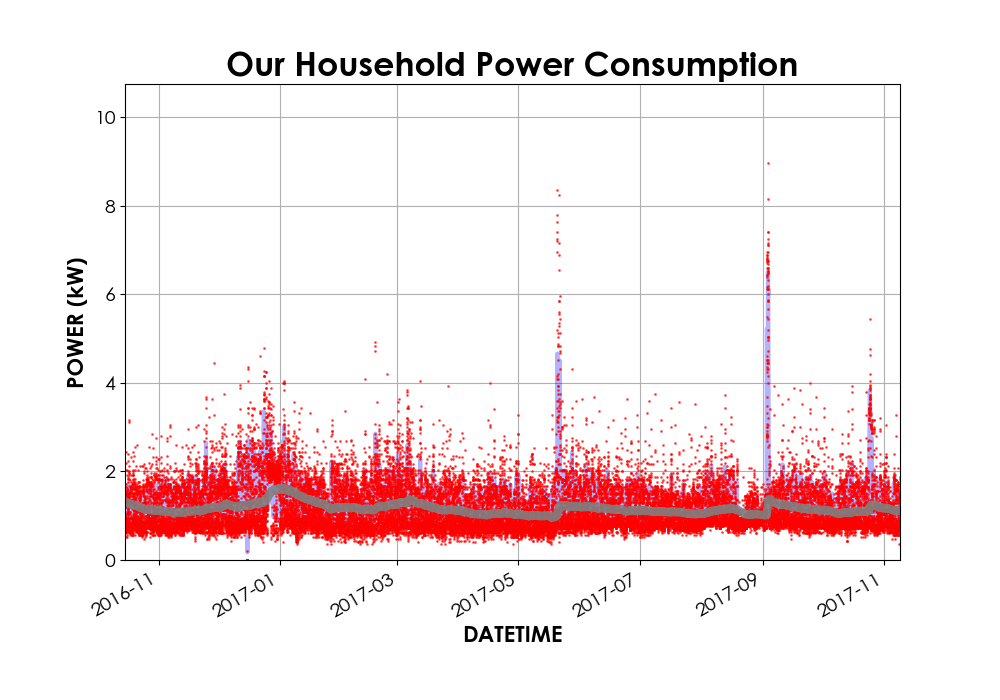

<IPython.core.display.Javascript object>


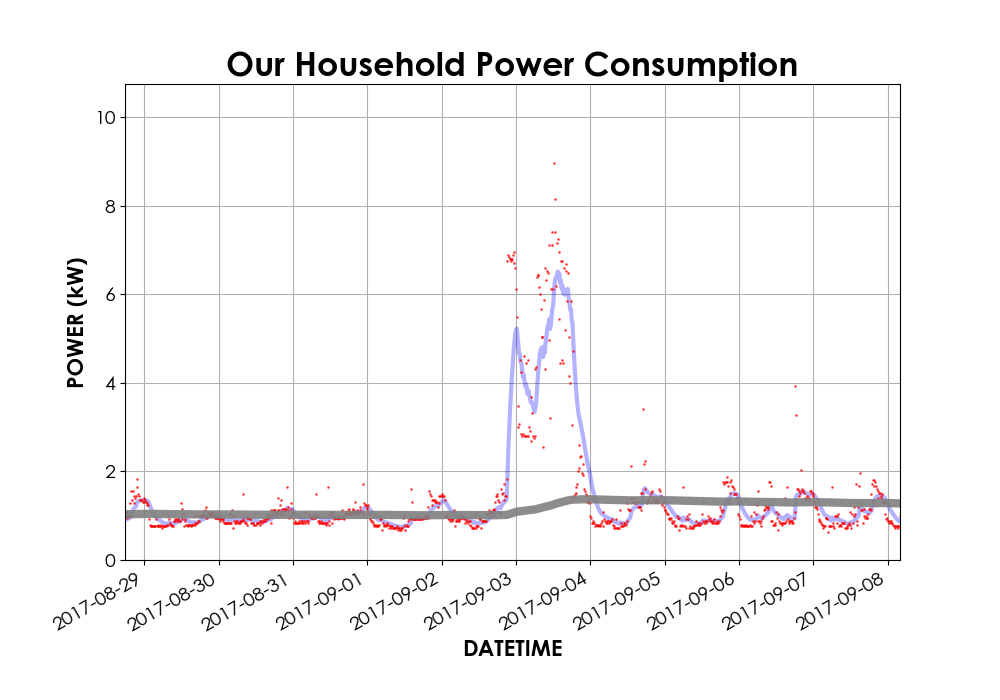

<IPython.core.display.Javascript object>


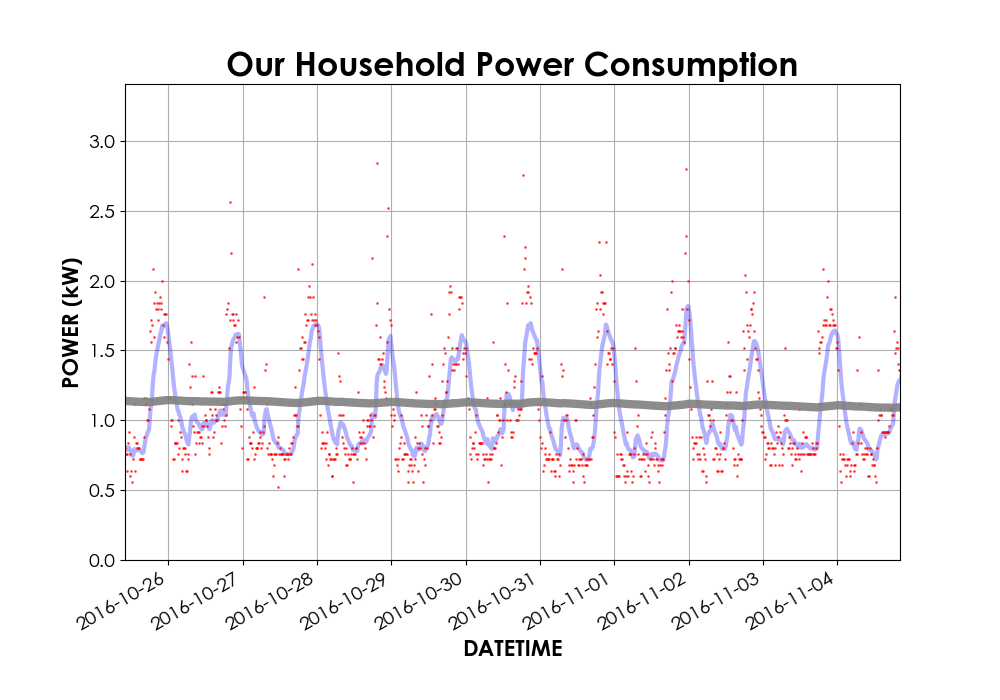

In [35]:
%matplotlib notebook

times = [ts.to_pydatetime() for ts in list(df.time_window)]
energy = np.array(df.kWh)
power = list(energy*4)
avg_1 = moving_avg(power, bias=0.9) 
avg_2 = moving_avg(power, bias=0.999)
avg = {'avg_1': avg_1, 'avg_2': avg_2}
data = {'times': times, 'power': power, 'avg': avg, 'energy': energy}

def plot_power_history(data, start=0, length=1000, partial=False):
    '''
    USAGE: Create a plot of power vs. datetime.
    
    ARGUMENTS:
    data -- dictionary of datasets
    start -- index of first element to be plotted (with partial=True)
    length -- total number of values to be plotted (with partial=True)
    partial -- False if whole dataset it plotted, True otherwise
    '''
    
    font = {'family': 'Century Gothic', 'weight': 'normal', 'size' : 14}
    plt.rc('font', **font)
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(data['times'], data['avg']['avg_1'], 'blue', linewidth = 3, alpha = 0.3)
    ax.plot(data['times'], data['power'], 'r.', ms = 2, alpha = 0.6)
    ax.plot(data['times'], data['avg']['avg_2'], 'gray', linewidth = 6, alpha = 0.9)
    ax.set_xlabel('DATETIME', fontdict = {'fontsize': 16, 'weight': 'bold'})
    ax.set_ylabel('POWER (kW)', fontdict = {'fontsize': 16, 'weight': 'bold'})
    ax.set_title('Our Household Power Consumption', fontdict = {'fontsize': 24, 'weight': 'bold'})
    ax.grid(True)
    plt.gcf().autofmt_xdate()

    end = -1
    if partial:
        end = start + length + 1
        if end > len(data['times']) - 1:
            end = -1

    _ = plt.axis([data['times'][start], data['times'][end], 0, 1.2*max(data['power'][start:end])])

    plt.show()
#     plt.savefig('plot_name.png', format='png', dpi=1000)
    
plot_power_history(data)
plot_power_history(data, start = 30500, partial = True)
plot_power_history(data, start = 1000, partial = True)

<IPython.core.display.Javascript object>


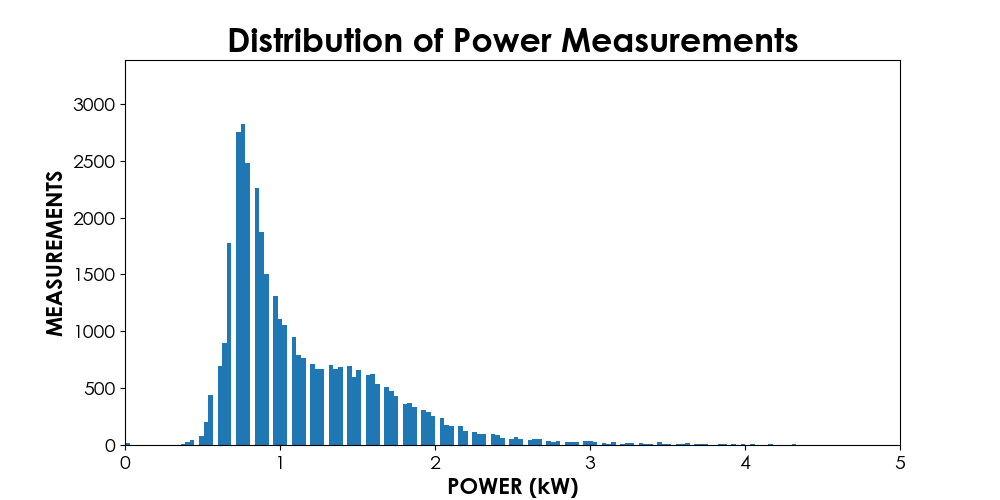

In [36]:
def plot_power_hist(data):
    '''
    USAGE: Plot a histogram of power measurements.
    ARGUMENT: data -- dictionary of datasets
    '''
    
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(1, 1, 1)
    n, bins, _ = plt.hist(data['power'], bins = 300)
    ax.set_xlabel('POWER (kW)', fontdict = {'fontsize': 16, 'weight': 'bold'})
    ax.set_ylabel('MEASUREMENTS', fontdict = {'fontsize': 16, 'weight': 'bold'})
    ax.set_title('Distribution of Power Measurements', fontdict = {'fontsize': 24, 'weight': 'bold'})
    _ = plt.axis([0, 5, 0, 1.2*max(n)])
    
plot_power_hist(data)
plt.savefig('Plots/hist_1.png', format='png', dpi=1000)